# Flood hazard map of the World - 50-year return period

Converts the georiff image file to HDF5, such that the water level is given as a function of latitude and longitude.

Data source: https://data.jrc.ec.europa.eu/dataset/jrc-floods-floodmapgl_rp50y-tif 

In [1]:
import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform

In [2]:
fname = '/network/home/barinpvi/floodMap/floodMapGL_rp50y.tif'

# Read raster
with rasterio.open(fname) as r:
    T0 = r.transform  # upper-left pixel corner affine transform
    p1 = Proj(r.crs)
    A = r.read()  # pixel values

In [3]:
# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

In [4]:
cols.shape

(16468, 41616)

In [6]:
rows.shape

(16468, 41616)

In [4]:
# Get affine transform for pixel centres
T1 = T0 * Affine.translation(0.5, 0.5)

In [5]:
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: (c, r) * T1

In [7]:
east = np.array([]).reshape(0, 41616)
north = np.array([]).reshape(0, 41616)
n = 30
for i in range(0, len(cols), n):
    eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows[i:i + n], cols[i:i + n])
    print(i)
    east = np.concatenate((east, eastings), axis=0)
    north = np.concatenate((north, northings), axis=0)

0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
1020
1050
1080
1110
1140
1170
1200
1230
1260
1290
1320
1350
1380
1410
1440
1470
1500
1530
1560
1590
1620
1650
1680
1710
1740
1770
1800
1830
1860
1890
1920
1950
1980
2010
2040
2070
2100
2130
2160
2190
2220
2250
2280
2310
2340
2370
2400
2430
2460
2490
2520
2550
2580
2610
2640
2670
2700
2730
2760
2790
2820
2850
2880
2910
2940
2970
3000
3030
3060
3090
3120
3150
3180
3210
3240
3270
3300
3330
3360
3390
3420
3450
3480
3510
3540
3570
3600
3630
3660
3690
3720
3750
3780
3810
3840
3870
3900
3930
3960
3990
4020
4050
4080
4110
4140
4170
4200
4230
4260
4290
4320
4350
4380
4410
4440
4470
4500
4530
4560
4590
4620
4650
4680
4710
4740
4770
4800
4830
4860
4890
4920
4950
4980
5010
5040
5070
5100
5130
5160
5190
5220
5250
5280
5310
5340
5370
5400
5430
5460
5490
5520
5550
5580
5610
5640
5670
5700
5730
5760
5790
5820
5850
5880
5910
5940
5970
6000
6030
6060
6090
6120
6150
6180
6210

In [8]:
east.shape

(16468, 41616)

In [9]:
north.shape

(16468, 41616)

In [10]:
eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows[16440:16468], cols[16440:16468])
east = np.concatenate((east, eastings), axis=0)
north = np.concatenate((north, northings), axis=0)

In [11]:
print(east.shape)

print(north.shape)

(16496, 41616)
(16496, 41616)


In [12]:
# Project all longitudes, latitudes
p2 = Proj(proj='latlong',datum='WGS84')
longs, lats = transform(p1, p2, east, north)

In [15]:
longs.ravel().shape

(686497536,)

In [19]:
import h5py

f = h5py.File("inland_flood.h5", "a")

In [20]:
f.create_dataset('longitude', data=longs.ravel())
f.create_dataset('latitude', data=lats.ravel())
f.create_dataset('pixel', data=A[0].ravel())
f.close()

In [22]:
f = h5py.File("inland_flood.h5", "r")

list(f.keys())

In [66]:
lat = np.array(f['latitude'])

long = np.array(f['longitude'])

In [59]:
full_pix = np.array(f['pixel'], dtype=np.float64)

In [74]:
f.close()

In [62]:
min(full_pix)

-3.4028230607370965e+38

In [63]:
max(full_pix)

30.0

## Do not use values < 0

In [71]:
idx = np.where(full_pix > 0)

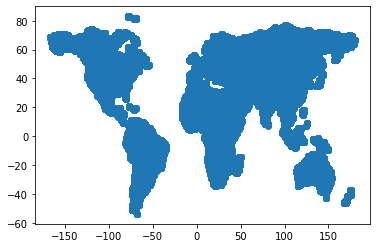

In [72]:
plt.scatter(long[idx], lat[idx])

In [73]:
long[idx].shape

(11480562,)

In [75]:
f = h5py.File("inland_continent_flood.h5", "a")
f.create_dataset('longitude', data=long[idx])
f.create_dataset('latitude', data=long[idx])
f.create_dataset('water_level', data=full_pix[idx])
f.close()

In [76]:
f = h5py.File("inland_continent_flood.h5", "r")

In [77]:
f.keys()

<KeysViewHDF5 ['latitude', 'longitude', 'water_level']>